In [1]:
from am4pa.linnea import LinneaConfig, DataManagerLinnea
from va4algs import RankingDataLinnea
from va4algs import DataAnalyzer3Way
from va4algs import RankingModel
import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
linnea_config = LinneaConfig("gls.py")
exp_id = "GLS"
linnea_config.set_local_directory("codes/{}".format(exp_id))
linnea_config.setup_backend_details(server="login18-1.hpc.itc.rwth-aachen.de",
                                   uname = "as641651",
                                   init_script="~/.analyzer",
                                   backend_root="~/PhD/va4algs-exps/")
linnea_config.connect_backend()

In [3]:
dml = DataManagerLinnea(linnea_config)

{'problem': 'gls.py', 'backend': True, 'server': 'login18-1.hpc.itc.rwth-aachen.de', 'uname': 'as641651', 'local_dir': 'codes/GLS', 'backend_dir': '~/PhD/va4algs-exps/GLS'}


In [4]:
dml.operands_data

{'12T': ['1000_10',
  '1000_100',
  '1000_150',
  '1000_200',
  '1000_300',
  '100_1000']}

In [5]:
dml.measurements_data

{'12T': {'1000_10': ['1'],
  '1000_100': ['1', '2', '4'],
  '1000_150': ['1', '2', '4'],
  '1000_200': ['1', '2', '4'],
  '1000_300': ['1', '2', '4'],
  '100_1000': ['1', '2', '4']}}

In [17]:
rm = RankingModel()
rdl = RankingDataLinnea(dml,rm,'12T')

In [18]:
rdl.load()

In [19]:
rdl.data_kernels

,node,class,operands,flops,kernel
0,gemm_1e+04,0,1000_10,10000.0,gemm
1,gemm_2e+05,0,1000_10,200000.0,gemm
2,gemv_10,1,1000_10,10.0,gemv
3,gemv_1e+04,0,1000_10,10000.0,gemv
4,gemv_1e+06,0,1000_10,1000000.0,gemv
...,...,...,...,...,...
79,syrk_1e+08,0,100_1000,100000000.0,syrk
80,transpose_1,-1,100_1000,1.0,transpose
81,trsm_1e+07,0,100_1000,10000000.0,trsm
82,trsv_1e+04,0,100_1000,10000.0,trsv


In [20]:
da = DataAnalyzer3Way(rdl.data_kernels, rdl.data_relations,rdl.data_ext)

In [31]:
da.discover_kernel_rules()

,index,kernel,case:rel-flops,-1,0,1,total,good (%),bad (%),selection score
0,6,transpose,0.0,5,0,0,5,0.0,1.0,0.0


In [32]:
da.rules

{'kernel': {1: [], -1: ['transpose']}, 'relation': {1: [], -1: []}}

In [22]:
da.discover_relations_rules()

class,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,37,trsm,qr,1,0,0,1,0.0,1.0,0.0


In [23]:
da.discover_kernel_anomalies()

,kernel,case:rel-flops,-1,0,1,total,good (%),bad (%),selection score


In [24]:
#kernel = 'LAPACK.syev'
#kernel = 'transpose'
kernel = 'gemm'
ops = da.find_operands_on_cl(-1, kernel)
ops

['1000_100', '1000_300', '1000_200', '1000_10', '1000_150']

In [101]:
#de.data_vcs[ops[-1]].get_dfg_minus_best_worst()

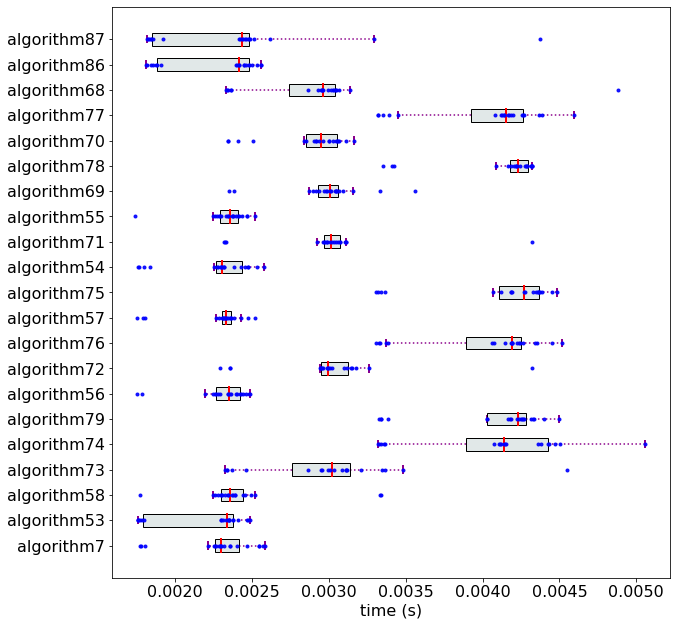

In [103]:
op_str = '1000_100'
a1 = de.get_algs_with_kernel(op_str, kernel)
a2 = de.get_best_algs(op_str)
fig = de.visualize_box_plots(op_str, a2+a1, scale=0.5)

['1000_100', '1000_150', '1000_200', '1000_300']


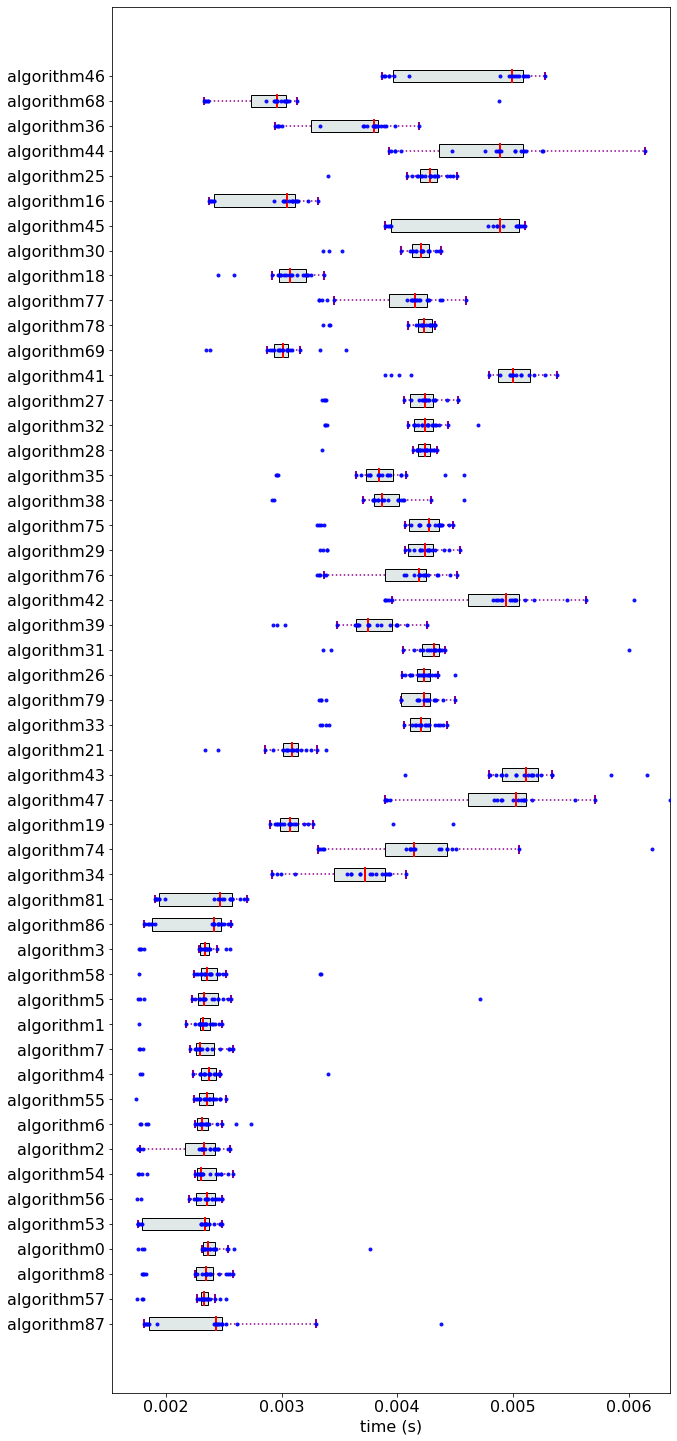

In [79]:
# kernelA = "trsm"
# kernelB = "trsm"
kernelA = "gemv"
kernelB = "gemv"
# kernelA = "trsm"
# kernelB = "gemv"
ops = da.find_operands_on_cl(-1, kernelA, kernelB)
print(ops)
# op_str = "100_1000"
op_str = "1000_100"
a3 = de.get_algs_with_relation(op_str, kernelA, kernelB)
a2 = de.get_best_algs(op_str)
fig = de.visualize_box_plots(op_str, a2+a3, scale=0.5)

In [25]:
dy = da.filter_relations_not_in_rules()
dy

class,level_0,index,kernelA,kernelB,-1,0,1,total,good (%),bad (%),selection score
0,5,6,gemm,syev,3,1,0,4,0.00,0.75,0.00
1,4,5,gemm,qr,3,1,0,4,0.00,0.75,0.00
2,43,46,trsv,syev,4,1,0,5,0.00,0.80,0.00
3,29,30,syrk,syev,4,1,0,5,0.00,0.80,0.00
4,25,26,syev,trsv,4,1,0,5,0.00,0.80,0.00
5,8,9,gemv,@@endnode,8,2,1,11,0.09,0.73,0.11
6,42,45,trsv,qr,5,0,1,6,0.17,0.83,0.17
7,21,22,qr,gemv,9,0,2,11,0.18,0.82,0.18
8,37,40,trsm,trsv,4,6,1,11,0.09,0.36,0.20
9,28,29,syrk,qr,4,0,1,5,0.20,0.80,0.20


In [26]:
da.train_dtree_classifiers(dy['kernelA'].to_list(),dy['kernelB'].to_list()) 

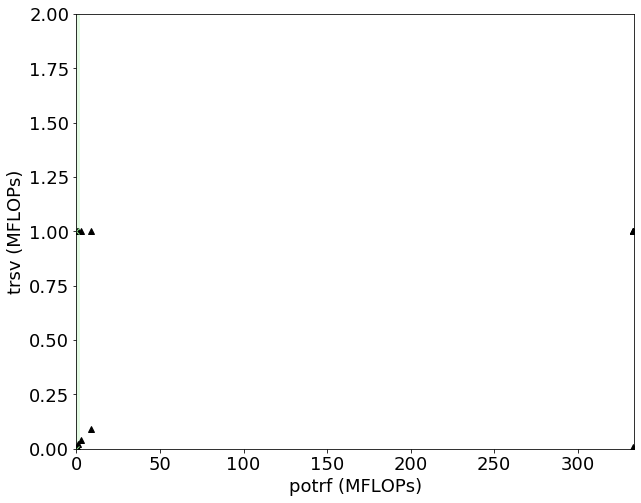

In [28]:
kernelA = 'potrf'
kernelB = 'trsv'
# kernelA = 'gemv'
# kernelB = 'trsv'
# kernelA = 'trsm'
# kernelB = 'gemv'
fig = da.get_regions_plot(kernelA, kernelB)

In [29]:
da.discover_impurities()

,kernelA,flopsA,kernelB,flopsB,class,impurity
54,gemv,200000.0,@@endnode,0.0,"[0, -1]",0.50
195,trsm,10000000.0,trsm,10000000.0,"[-1, 0]",0.50
197,trsm,10000000.0,trsv,1000000.0,"[0, -1]",0.50
272,trsv,1000000.0,trsm,10000000.0,"[0, -1]",0.50
280,trsv,1000000.0,trsv,1000000.0,"[-1, -1, -1, -1, 0]",0.32


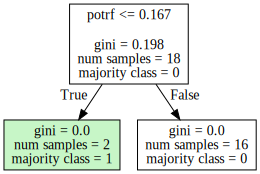

In [30]:
dtree = da.get_dtree(kernelA, kernelB)
dtree

['1000_100', '1000_150', '1000_200', '100_1000', '1000_300']


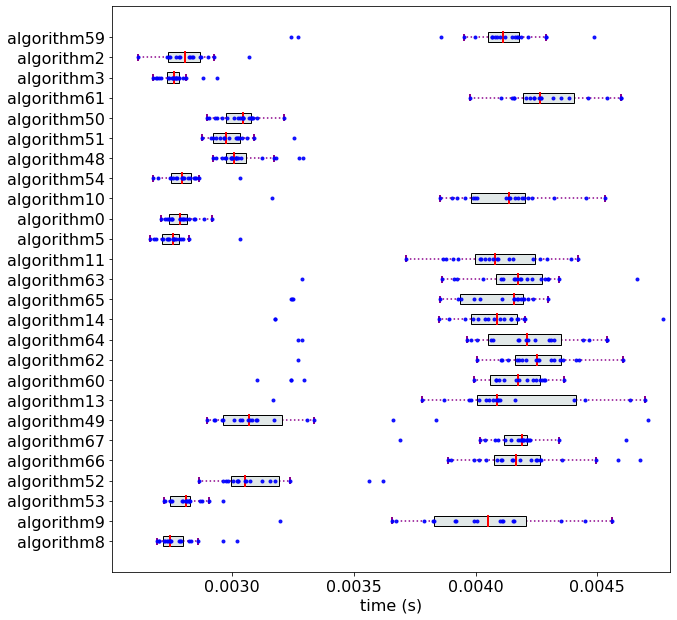

In [120]:
ops = da.find_operands_on_cl(-1, kernelA, kernelB)
print(ops)
op_str = '1000_200'
#a5 = de.get_algs_with_relation_flops(op_str, kernelA, '<', 0.2, kernelB, '<', 0.2)
a5 = de.get_algs_with_relation_flops(op_str, kernelA, '>', 0.2, kernelB, '<', 0.065)
#a5 = de.get_algs_with_relation_flops(op_str, kernelA, '<', 200.0, kernelB, '>', 0.065)
a1 = de.get_best_algs(op_str)
a1_ = [a for a in a1 if a not in a5]
#print(a1_)
fig = de.visualize_box_plots(op_str, a1_+a5, scale=0.4)